
# Лабораторная работа №1  
## Построение модели линейной и гребневой регрессии на данных по ожидаемой продолжительности жизни

**Цель работы:** исследовать зависимость ожидаемой продолжительности жизни населения от социально-экономических и медицинских показателей на примере датасета *Life Expectancy (WHO)* с Kaggle, а также сравнить качество моделей линейной и гребневой регрессии на исходном признаковом пространстве и в пространстве главных компонент (PCA) с использованием кросс-валидации.

В работе выполняются следующие шаги:

1. Загрузка и описание датасета.
2. Первичный анализ данных, обработка пропусков, выбор целевой переменной и признаков.
3. Построение матрицы корреляций и анализ мультиколлинеарности (в том числе расчёт VIF).
4. Масштабирование признаков и обучение моделей линейной и гребневой регрессии.
5. Оценка качества моделей на тестовой выборке и с помощью K-fold кросс-валидации по метрикам RMSE, R² и MAPE с подробной интерпретацией.
6. Снижение размерности признаков методом главных компонент (PCA), анализ доли объясняемой дисперсии и матрицы факторных нагрузок.
7. Повторное обучение линейной и гребневой регрессии на пространстве главных компонент и сравнение качества с моделями на исходных признаках.
8. Формирование выводов по результатам экспериментов.


### 1. Подключение библиотек и загрузка данных

In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option("display.max_columns", 100)


### 2. Загрузка и первичный анализ датасета

In [2]:

df = pd.read_csv("Life Expectancy Data.csv")

df.head()


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               


Из описания видно, что:

* Наблюдения представляют собой страну и год.
* Целевая переменная — `Life expectancy` (ожидаемая продолжительность жизни).
* Присутствуют как числовые, так и категориальные переменные (`Country`, `Status`).


### 3. Обработка пропусков и выбор признаков

In [4]:

missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


Population                         652
Hepatitis B                        553
GDP                                448
Total expenditure                  226
Alcohol                            194
Income composition of resources    167
Schooling                          163
 thinness 5-9 years                 34
 thinness  1-19 years               34
 BMI                                34
Polio                               19
Diphtheria                          19
Life expectancy                     10
Adult Mortality                     10
dtype: int64


Для упрощения лабораторной работы и сохранения максимального числа наблюдений
выполним заполнение пропусков по числовым признакам средним значением по столбцу,
а пропуски в категориальных переменных оставим без изменений (или при необходимости
будем их игнорировать).


In [5]:

df_raw = df.copy()

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

df.isna().sum().sum()


0


В качестве целевой переменной используем столбец `Life expectancy`.

В пространство признаков не включаем:
* `Country` — категориальный признак с большим количеством уровней;
* `Year` — можно использовать, но он скорее задаёт тренд по времени;
* Целевую переменную `Life expectancy` из матрицы признаков.

Категориальный признак `Status` (Developing/Developed) закодируем бинарно.


In [6]:

df["Status_bin"] = (df["Status"] == "Developed").astype(int)

feature_cols = [col for col in df.columns 
                if col not in ["Life expectancy ", "Life expectancy", "Country", "Status"]]

target_col = "Life expectancy " if "Life expectancy " in df.columns else "Life expectancy"

X = df[feature_cols]
y = df[target_col]

X.head(), y.head()


(   Year  Adult Mortality  infant deaths  Alcohol  percentage expenditure  \
 0  2015            263.0             62     0.01               71.279624   
 1  2014            271.0             64     0.01               73.523582   
 2  2013            268.0             66     0.01               73.219243   
 3  2012            272.0             69     0.01               78.184215   
 4  2011            275.0             71     0.01                7.097109   
 
    Hepatitis B  Measles    BMI   under-five deaths   Polio  Total expenditure  \
 0         65.0      1154   19.1                  83    6.0               8.16   
 1         62.0       492   18.6                  86   58.0               8.18   
 2         64.0       430   18.1                  89   62.0               8.13   
 3         67.0      2787   17.6                  93   67.0               8.52   
 4         68.0      3013   17.2                  97   68.0               7.87   
 
    Diphtheria    HIV/AIDS         GDP  Po

### 4. Корреляционный анализ и оценка мультиколлинеарности (VIF)

In [7]:

corr_with_target = X.join(y).corr()[target_col].sort_values(ascending=False)
corr_with_target


Life expectancy                    1.000000
Schooling                          0.715066
Income composition of resources    0.692483
 BMI                               0.559255
Status_bin                         0.481962
Diphtheria                         0.475418
Polio                              0.461574
GDP                                0.430493
Alcohol                            0.391598
percentage expenditure             0.381791
Total expenditure                  0.207981
Hepatitis B                        0.203771
Year                               0.169623
Population                        -0.019638
Measles                           -0.157574
infant deaths                     -0.196535
under-five deaths                 -0.222503
 thinness 5-9 years               -0.466629
 thinness  1-19 years             -0.472162
 HIV/AIDS                         -0.556457
Adult Mortality                   -0.696359
Name: Life expectancy , dtype: float64

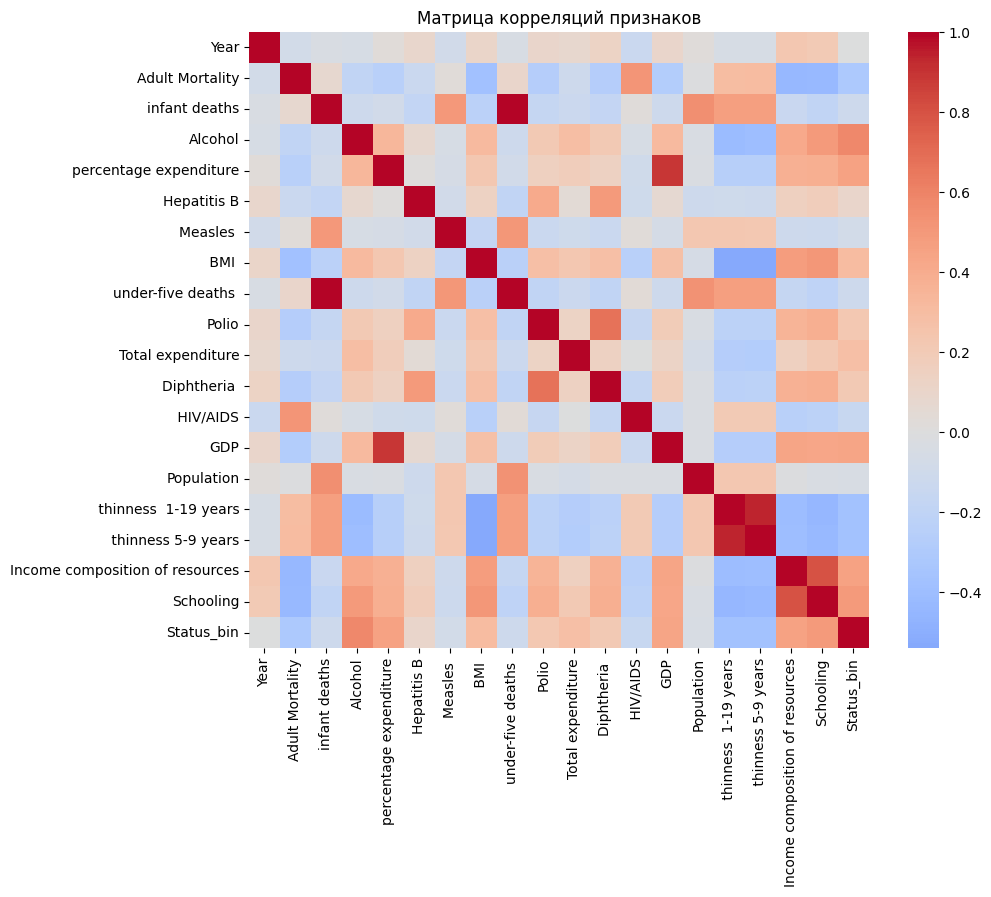

In [8]:

plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Матрица корреляций признаков")
plt.show()


Матрица корреляций показала, что ряд признаков сильно связан между собой. Особенно выражена зависимость между показателями детской смертности: infant deaths и under-five deaths имеют практически линейную связь, что подтверждается экстремально высокими значениями VIF (≈176 и ≈176 соответственно). Аналогичная картина наблюдается для пары показателей истощённости thinness 1–19 years и thinness 5–9 years (VIF около 8.8), а также для экономических переменных GDP и percentage expenditure (VIF порядка 5.1–5.2).

Большинство остальных признаков имеют умеренные значения VIF (от 1 до 3), что говорит о приемлемом уровне мультиколлинеарности. Таким образом, мультиколлинеарность в исходных данных явно присутствует, но сконцентрирована в нескольких группах тесно связанных показателей, в первую очередь — в блоке переменных, характеризующих детскую смертность и истощённость.

In [9]:

X_vif = sm.add_constant(X)

vif_data = []
for i, col in enumerate(X_vif.columns):
    if col == "const":
        continue
    vif = variance_inflation_factor(X_vif.values, i)
    vif_data.append({"feature": col, "VIF": vif})

vif_df = pd.DataFrame(vif_data).sort_values(by="VIF", ascending=False)
vif_df


,feature,VIF
2,infant deaths,176.813940
8,under-five deaths,175.818185
16,thinness 5-9 years,8.866095
15,thinness 1-19 years,8.776175
13,GDP,5.235153
4,percentage expenditure,5.073441
18,Schooling,3.347887
17,Income composition of resources,3.088640
11,Diphtheria,2.218235
9,Polio,1.948786


### 5. Масштабирование признаков и обучение линейной и гребневой регрессии


Перед обучением моделей, чувствительных к масштабу признаков (в частности, гребневая регрессия и PCA),
необходимо выполнить стандартизацию признаков: привести их к нулевому среднему и единичному стандартному отклонению.


In [10]:

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((2350, 20), (588, 20))

In [11]:

# Линейная регрессия
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_pred_lin = linreg.predict(X_test_scaled)

# Гребневая регрессия
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)


### 6. Метрики качества моделей и их интерпретация


В работе используются следующие метрики качества регрессионной модели:

* **RMSE (Root Mean Square Error, корень из среднеквадратичной ошибки)**  
  \[
  \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
  \]  
  Показывает среднее отклонение прогнозов от реальных значений в тех же единицах, 
  что и целевая переменная (в нашем случае — в годах ожидаемой продолжительности жизни).
  Чувствителен к выбросам, так как ошибку возводят в квадрат.

* **R² (коэффициент детерминации)**  
  \[
  R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
  \]  
  Характеризует долю дисперсии целевой переменной, объясняемую моделью.  
  Значение близко к 1 означает, что модель хорошо описывает вариацию данных; 
  значение, близкое к 0, — что модель мало информативна.

* **MAPE (Mean Absolute Percentage Error, средняя абсолютная процентная ошибка)**  
  \[
  \text{MAPE} = \frac{100\%}{n} \sum_{i=1}^n \left| \frac{y_i - \hat{y}_i}{y_i} \right|
  \]  
  Показывает среднюю относительную ошибку модели в процентах. 
  Удобна для интерпретации, но неустойчива к нулевым и очень малым значениям целевой переменной.


In [12]:

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5  # или np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return rmse, r2, mape

metrics_lin = regression_metrics(y_test, y_pred_lin)
metrics_ridge = regression_metrics(y_test, y_pred_ridge)

pd.DataFrame(
    [metrics_lin, metrics_ridge],
    columns=["RMSE", "R2", "MAPE, %"],
    index=["LinearRegression", "Ridge(alpha=1.0)"]
)


,RMSE,R2,"MAPE, %"
LinearRegression,3.904220,0.824056,4.400850
Ridge(alpha=1.0),3.908696,0.823653,4.403772


На исходном стандартизованном признаковом пространстве были обучены модели линейной и гребневой регрессии. На тестовой выборке получены следующие значения метрик:
1) LinearRegression:
RMSE ≈ 3.90 года, R² ≈ 0.824, MAPE ≈ 4.40 %.
2) Ridge (α = 1.0):
RMSE ≈ 3.91 года, R² ≈ 0.824, MAPE ≈ 4.40 %.

Интерпретируя результаты, можно отметить, что обе модели объясняют около 82–83 % вариации ожидаемой продолжительности жизни (R² ≈ 0.82), что свидетельствует о высокой информативности выбранных признаков. Средняя ошибка порядка 3.9 года на фоне типичных значений продолжительности жизни 50–80 лет является умеренной и приемлемой для задач такого уровня агрегированности. Средняя относительная ошибка около 4.4 % показывает, что в среднем прогноз отличается от фактического значения менее чем на пять процентов, что также можно считать хорошим качеством для социально-демографических данных.

Различия между линейной и гребневой регрессией по метрикам минимальны, что ожидаемо при хорошо обусловленных данных и относительно мягкой регуляризации (α = 1.0).

### 7. K-fold кросс-валидация


Для более надёжной оценки качества моделей используем **K-fold кросс-валидацию** (K=5):

* Данные делятся на 5 непересекающихся блоков (folds).
* На каждом шаге 4 блока используются для обучения модели, 1 — для валидации.
* Итоговая оценка метрики — среднее значение по всем 5 разбиениям.

Это позволяет уменьшить зависимость качества модели от случайного разбиения выборки на обучающую и тестовую.


In [13]:

import numpy as np

def rmse_func(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scaler_cv = StandardScaler()
X_scaled_full = scaler_cv.fit_transform(X)

linreg_cv = LinearRegression()
ridge_cv = Ridge(alpha=1.0, random_state=42)

rmse_scorer = make_scorer(rmse_func, greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

def cv_results(model, X_data, y_data, kf):
    rmse_scores = -cross_val_score(model, X_data, y_data, scoring=rmse_scorer, cv=kf)
    r2_scores = cross_val_score(model, X_data, y_data, scoring="r2", cv=kf)
    mape_scores = -cross_val_score(model, X_data, y_data, scoring=mape_scorer, cv=kf) * 100
    return rmse_scores, r2_scores, mape_scores

rmse_lin, r2_lin, mape_lin = cv_results(linreg_cv, X_scaled_full, y, kfold)
rmse_ridge, r2_ridge, mape_ridge = cv_results(ridge_cv, X_scaled_full, y, kfold)

cv_table = pd.DataFrame({
    "Model": ["LinearRegression", "Ridge(alpha=1.0)"],
    "RMSE_mean": [rmse_lin.mean(), rmse_ridge.mean()],
    "RMSE_std": [rmse_lin.std(), rmse_ridge.std()],
    "R2_mean": [r2_lin.mean(), r2_ridge.mean()],
    "R2_std": [r2_lin.std(), r2_ridge.std()],
    "MAPE_mean, %": [mape_lin.mean(), mape_ridge.mean()],
    "MAPE_std, %": [mape_lin.std(), mape_ridge.std()],
})
cv_table


,Model,RMSE_mean,RMSE_std,R2_mean,R2_std,"MAPE_mean, %","MAPE_std, %"
0,LinearRegression,4.068730,0.113913,0.815762,0.012438,4.647999,0.177987
1,Ridge(alpha=1.0),4.069671,0.108813,0.815699,0.011873,4.645916,0.177467



Для более надёжной оценки качества использована 5-кратная перекрёстная проверка на всём наборе наблюдений. Усреднённые по фолдам метрики имеют вид:
1) LinearRegression:
RMSE_mean ≈ 4.07 ± 0.11,
R²_mean ≈ 0.816 ± 0.012,
MAPE_mean ≈ 4.65 ± 0.18 %.
2) Ridge (α = 1.0):
RMSE_mean ≈ 4.07 ± 0.11,
R²_mean ≈ 0.816 ± 0.012,
MAPE_mean ≈ 4.65 ± 0.18 %.

Средние значения метрик по кросс-валидации близки к результатам на одном фиксированном train/test-разбиении, а разброс (стандартные отклонения) невелик. Это означает, что качество моделей устойчиво к выбору конкретного разбиения выборки, и полученные оценки не являются следствием удачного или неудачного разделения данных. Гребневая регрессия по своим метрикам практически совпадает с обычной линейной, при этом демонстрируя сопоставимую устойчивость.

### 8. Снижение размерности методом главных компонент (PCA) и матрица факторных нагрузок


Метод главных компонент (Principal Component Analysis, PCA) позволяет:

* Преобразовать исходные коррелированные признаки в новый набор **некоррелированных главных компонент**.
* Сконцентрировать большую часть дисперсии данных в первых нескольких компонентах, тем самым **снизив размерность**.
* Борьба с мультиколлинеарностью: в пространстве главных компонент корреляции между новыми признаками отсутствуют.

PCA проводится по стандартизованным данным.


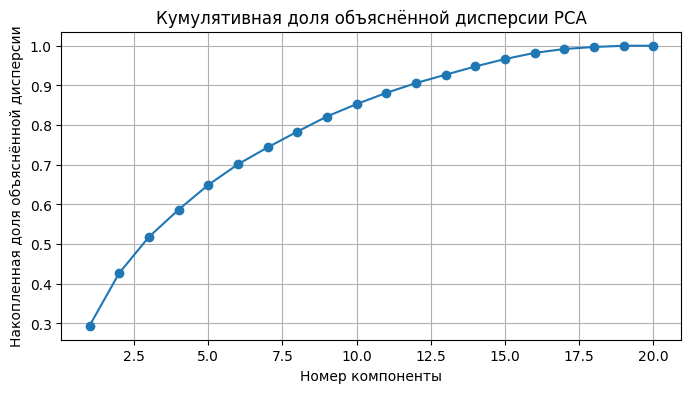

array([0.294005  , 0.42680858, 0.51776361, 0.58654308, 0.64889162,
       0.70091   , 0.74355708, 0.78327348, 0.82148228, 0.85282793,
       0.88094431, 0.90573051, 0.92684725, 0.94766286, 0.96633517,
       0.98197159, 0.99165678, 0.99684169, 0.99985784, 1.        ])

In [14]:

pca = PCA()
pca.fit(X_scaled_full)

explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance) + 1), cum_explained_variance, marker="o")
plt.xlabel("Номер компоненты")
plt.ylabel("Накопленная доля объяснённой дисперсии")
plt.title("Кумулятивная доля объяснённой дисперсии PCA")
plt.grid(True)
plt.show()

cum_explained_variance


Анализ кумулятивной доли объяснённой дисперсии показал, что первые компоненты PCA аккумулируют большую часть информации исходных признаков. Уже к 14-й компоненте суммарная объяснённая дисперсия достигает уровня около 95 %, а дальнейшее увеличение числа компонент даёт лишь незначительный прирост.

Таким образом, переход от исходного пространства из 20 признаков к пространству из 14 главных компонент позволяет существенно снизить размерность при сохранении основного объёма вариации данных. Это особенно важно с учётом выявленной ранее сильной мультиколлинеарности в группах признаков, отвечающих за детскую смертность и истощённость.

Матрица факторных нагрузок показывает, что первые компоненты формируются за счёт комбинаций наиболее информативных показателей (показателей смертности, истощённости, а также социально-экономических индикаторов уровня дохода и образования), тогда как последующие компоненты отражают более частные вариации отдельных переменных. Это позволяет интерпретировать первые главные компоненты как обобщённые факторы состояния здоровья населения и социально-экономического развития.

In [15]:

n_components_95 = np.argmax(cum_explained_variance >= 0.95) + 1
n_components_95


15

In [16]:

pca_95 = PCA(n_components=n_components_95)
X_pca = pca_95.fit_transform(X_scaled_full)

X_pca.shape


(2938, 15)


#### Матрица факторных нагрузок (loadings)

Факторные нагрузки показывают вклад исходного признака в каждую главную компоненту
и позволяют интерпретировать факторы, сформированные PCA.


In [17]:

loadings = pd.DataFrame(
    pca_95.components_.T,
    columns=[f"PC{i+1}" for i in range(n_components_95)],
    index=X.columns
)

loadings


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
Year,0.071037,0.042122,0.189914,-0.082063,-0.296872,0.765092,0.070678,0.246892,-0.208887,0.254681,-0.140183,-0.094169,0.178719,-0.148317,0.134786
Adult Mortality,-0.219382,-0.171193,-0.140159,0.325123,0.235096,0.257614,-0.218619,0.181134,0.077325,0.192171,-0.047805,-0.247927,-0.019190,0.516582,-0.469815
infant deaths,-0.211592,0.479136,0.033799,-0.074574,0.126160,0.026254,0.014011,0.062332,0.049078,0.017426,0.086737,-0.311800,-0.275110,-0.112058,0.022609
Alcohol,0.239143,0.138874,-0.199516,0.090645,0.374576,-0.023457,-0.064233,-0.236779,-0.224191,0.321219,-0.102369,-0.137839,0.155865,0.320449,0.592946
percentage expenditure,0.218220,0.216778,-0.299101,0.363004,-0.318356,-0.095054,0.112079,0.198819,0.154341,-0.025662,-0.006282,-0.010160,-0.024906,0.064497,0.068435
Hepatitis B,0.125972,-0.049380,0.455772,0.247064,0.100277,-0.157645,0.101701,0.257538,-0.147427,0.370233,0.602405,0.175539,-0.113502,0.028965,0.016911
Measles,-0.135710,0.309729,-0.024475,-0.098435,0.162200,-0.193803,-0.060439,0.525078,-0.491999,-0.241134,-0.171740,0.279602,0.314931,0.123953,-0.091851
BMI,0.272650,0.036596,0.013470,-0.263102,0.082528,0.067462,-0.133791,0.093606,0.258014,-0.299905,0.490142,-0.357367,0.530360,0.081469,-0.024129
under-five deaths,-0.216622,0.473048,0.019454,-0.071416,0.130823,0.023670,0.016318,0.072396,0.035742,0.026147,0.091884,-0.320332,-0.272502,-0.112451,0.032214
Polio,0.210846,0.049490,0.430829,0.217206,0.129067,-0.095193,-0.029000,0.004290,0.156235,-0.200674,-0.439459,-0.216671,0.095472,-0.062229,-0.046004


### 9. Линейная и гребневая регрессия на главных компонентах

In [18]:

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

linreg_pca = LinearRegression()
linreg_pca.fit(X_pca_train, y_pca_train)
y_pred_lin_pca = linreg_pca.predict(X_pca_test)

ridge_pca = Ridge(alpha=1.0, random_state=42)
ridge_pca.fit(X_pca_train, y_pca_train)
y_pred_ridge_pca = ridge_pca.predict(X_pca_test)

metrics_lin_pca = regression_metrics(y_pca_test, y_pred_lin_pca)
metrics_ridge_pca = regression_metrics(y_pca_test, y_pred_ridge_pca)

pd.DataFrame(
    [metrics_lin, metrics_ridge, metrics_lin_pca, metrics_ridge_pca],
    columns=["RMSE", "R2", "MAPE, %"],
    index=[
        "Linear (orig features)",
        "Ridge (orig features)",
        "Linear (PCA features)",
        "Ridge (PCA features)",
    ]
)


,RMSE,R2,"MAPE, %"
Linear (orig features),3.904220,0.824056,4.400850
Ridge (orig features),3.908696,0.823653,4.403772
Linear (PCA features),4.069657,0.808830,4.567453
Ridge (PCA features),4.069586,0.808836,4.567470


После перехода к пространству главных компонент были повторно обучены модели линейной и гребневой регрессии. Метрики на тестовой выборке приняли значения:
1) Linear (PCA features):
RMSE ≈ 4.07 года, R² ≈ 0.809, MAPE ≈ 4.57 %.
2) Ridge (PCA features):
RMSE ≈ 4.07 года, R² ≈ 0.809, MAPE ≈ 4.57 %.

По сравнению с моделями на исходных признаках наблюдается небольшое ухудшение показателей качества: RMSE увеличивается примерно на 0.15 года, R² снижается с ≈0.824 до ≈0.809, MAPE возрастает примерно с 4.40 % до 4.57 %. При этом размерность признакового пространства сокращена, а мультиколлинеарность устранена за счёт ортогональности главных компонент.

Иными словами, использование PCA позволяет получить более компактное и численно устойчивое представление данных, однако в данном случае это сопровождается небольшим снижением точности прогноза. Для задач интерпретации факторов и борьбы с мультиколлинеарностью такой компромисс оправдан, но для чисто прогностических целей несколько лучше выглядят модели на исходных признаках.

### 10. Выводы по работе

1) Мультиколлинеарность в исходных данных статистически значима и сосредоточена в отдельных группах признаков (детская смертность, истощённость, экономические расходы и ВВП), что подтверждается как матрицей корреляций, так и очень высокими значениями VIF для отдельных переменных.
2) Линейная и гребневая регрессии на исходном наборе признаков демонстрируют высокое качество: R² порядка 0.82, RMSE около 3.9 года и среднюю процентную ошибку порядка 4.4 %. Это означает, что модель объясняет большую часть вариации ожидаемой продолжительности жизни и обеспечивает достаточно точные прогнозы.
3) Результаты 5-кратной кросс-валидации близки к метрикам на тестовой выборке и имеют небольшой разброс, что свидетельствует об устойчивости моделей к выбору разбиения данных и отсутствии явного переобучения. Гребневая регрессия не даёт заметного выигрыша по метрикам, но обеспечивает регуляризацию коэффициентов в условиях мультиколлинеарности.
4) Метод главных компонент позволяет сократить размерность признакового пространства примерно до 14 ортогональных факторов при сохранении не менее 95 % общей дисперсии исходных данных. Главные компоненты агрегируют информацию о состоянии здоровья и социально-экономических условиях, что упрощает интерпретацию структуры данных.
5) Модели регрессии, обученные на главных компонентах, несколько уступают по качеству моделям на исходных признаках, однако обеспечивают более компактное и устойчивое к мультиколлинеарности представление. В терминах компромисса «точность–простота модели» PCA-подход может быть предпочтителен, если акцент делается на интерпретации факторов и устойчивости, а не на максимальном возможном качестве прогноза.